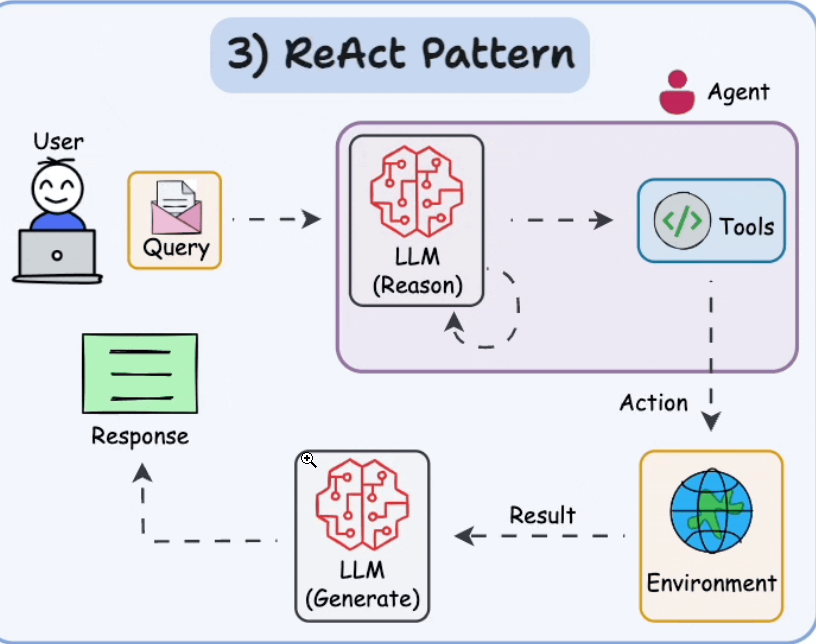

# ReAct Agent Lab: Building a Simple ReAct Agent in Python

This Jupyter Notebook lab is designed for students to learn about ReAct (Reasoning + Acting) agents. A ReAct agent uses an LLM (like GPT) to reason step by step, decide on actions (tool calls), observe the results, and continue until it reaches a final answer. We'll use the OpenAI API to power the agent.

The lab is structured to be easy to understand:
- Set up the environment.
- Define 7 simple tools (functions) that the agent can use.
- Implement the ReAct agent loop.
- Test the agent with 10 questions.


In [1]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

!pip install openai wikipedia sympy requests -q

# Clean up the notebook
clean_notebook()


Notebook cleaned.


In [2]:
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

In [3]:
import os
from openai import OpenAI
import wikipedia
from sympy import sympify
import requests
from datetime import date
import random

# Set up OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
model_name = "gpt-4o"  # Using 'gpt-4o' as a stand-in; change if needed to 'gpt-4.1' or another model

## Step 3: Define the 7 Tools

We'll create 7 functions as tools for the agent. Each tool takes a single string input and returns a string output. These are simple implementations for educational purposes:

1. **calculator**: Evaluates a mathematical expression (e.g., "2+3*4").
2. **web_search**: (Modified) Returns dummy mock search results (e.g., a list of fake titles, bodies, and links).
3. **browse_page**: Fetches and returns a snippet of content from a URL.
4. **wikipedia_lookup**: Searches Wikipedia for matching page titles.
5. **get_wikipedia_page**: Gets a snippet of content from a specific Wikipedia page.
6. **get_current_date**: Returns the current date (ignores input).
7. **generate_random_number**: Generates a random integer between two numbers (input: "low high").

In [4]:
import wikipedia
from sympy import sympify
import requests
from datetime import date
import random
import json

def calculator(expression: str) -> str:
    """Useful for mathematical calculations.
    
    Args:
        expression: A mathematical expression string (e.g., "2+3*4").
    
    Returns:
        The result of the calculation as a string.
    """
    try:
        return str(sympify(expression))
    except Exception as e:
        return f"Error: {e}"

def web_search(query: str) -> str:
    """Searches the internet for information.
    
    Args:
        query: The search query string.
        
    Returns:
        A JSON string of mock search results.
    """
    mock_results = [
        {"title": "Dummy Result 1", "body": f"Mock content for query: {query}", "href": "http://dummy.com/1"},
        {"title": "Dummy Result 2", "body": f"Another mock for: {query}", "href": "http://dummy.com/2"},
        {"title": "Dummy Result 3", "body": f"Third mock related to {query}", "href": "http://dummy.com/3"},
        {"title": "Dummy Result 4", "body": f"Fourth dummy entry on {query}", "href": "http://dummy.com/4"},
        {"title": "Dummy Result 5", "body": f"Final mock for search: {query}", "href": "http://dummy.com/5"}
    ]
    return json.dumps(mock_results)

def browse_page(url: str) -> str:
    """Fetches and returns a snippet of content from a URL.
    
    Args:
        url: The URL of the webpage.
        
    Returns:
        A string containing the first 2000 characters of the page content.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text[:2000]
    except requests.exceptions.RequestException as e:
        return f"Error fetching page: {e}"

def wikipedia_lookup(query: str) -> str:
    """Searches Wikipedia for matching page titles.
    
    Args:
        query: The search query string.
        
    Returns:
        A JSON string of Wikipedia page titles.
    """
    try:
        return json.dumps(wikipedia.search(query))
    except Exception as e:
        return f"Error: {e}"

def get_wikipedia_page(title: str) -> str:
    """Gets a snippet of content from a specific Wikipedia page.
    
    Args:
        title: The exact title of the Wikipedia page.
        
    Returns:
        A string containing the first 2000 characters of the page content.
    """
    try:
        page = wikipedia.page(title, auto_suggest=False)
        return page.content[:2000]
    except wikipedia.exceptions.PageError:
        return "Page not found"
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Disambiguation page. Possible options: {e.options}"
    except Exception as e:
        return f"Error: {e}"

def get_current_date() -> str:
    """Get the current date.
    
    Returns:
        The current date as a string (YYYY-MM-DD).
    """
    return str(date.today())

def generate_random_number(input_str: str) -> str:
    """Generates a random integer between two numbers.
    
    Args:
        input_str: A string with two space-separated numbers, e.g., "1 10".
        
    Returns:
        A random integer as a string.
    """
    try:
        low, high = map(int, input_str.split())
        return str(random.randint(low, high))
    except Exception as e:
        return f"Error: {e}"



In [5]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "calculator",
            "description": "Useful for mathematical calculations. Input: a mathematical expression like '2+3*4'.",
            "parameters": {
                "type": "object",
                "properties": {
                    "expression": {"type": "string", "description": "The mathematical expression to evaluate"}
                },
                "required": ["expression"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "web_search",
            "description": "Searches the internet for information. Input: a search query.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {"type": "string", "description": "The search query."}
                },
                "required": ["query"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "browse_page",
            "description": "Fetches and returns a snippet of content from a URL. Input: a URL.",
            "parameters": {
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "The URL of the webpage to browse."}
                },
                "required": ["url"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "wikipedia_lookup",
            "description": "Searches Wikipedia for page titles. Input: a query.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {"type": "string", "description": "The search query."}
                },
                "required": ["query"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_wikipedia_page",
            "description": "Gets content from a Wikipedia page. Input: the exact page title.",
            "parameters": {
                "type": "object",
                "properties": {
                    "title": {"type": "string", "description": "The exact page title."}
                },
                "required": ["title"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_current_date",
            "description": "Get the current date.",
            "parameters": {
                "type": "object",
                "properties": {}
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_random_number",
            "description": "Generates a random integer between two numbers. Input: a string with two space-separated numbers, e.g., '1 10'.",
            "parameters": {
                "type": "object",
                "properties": {
                    "input_str": {"type": "string", "description": "The range as a string, e.g., '1 10'."}
                },
                "required": ["input_str"]
            }
        }
    }
]


In [6]:

available_functions = {
    "calculator": calculator,
    "web_search": web_search,
    "browse_page": browse_page,
    "wikipedia_lookup": wikipedia_lookup,
    "get_wikipedia_page": get_wikipedia_page,
    "get_current_date": get_current_date,
    "generate_random_number": generate_random_number,
}

## Step 4: Define the System Prompt for the ReAct Agent

The system prompt instructs the model on how to behave. For tool-calling, we will now use the tools parameter in the API call instead of including the tool descriptions in the prompt. This is a more robust way to use tool-calling.



In [7]:
system_prompt = "You are a helpful assistant that uses tools to answer questions."

## Step 5: Implement the ReAct Agent Loop

This function runs the agent: it maintains a message history, generates responses, parses actions, executes tools, and adds observations until a final answer is reached.

In [8]:
def run_agent(query, max_steps=10):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query}
    ]
    
    print(f"Starting agent for query: {query}\n")
    
    for step in range(max_steps):
        print(f"--- Step {step + 1} ---")
        
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            tools=tools,
            tool_choice="auto"
        )
        
        response_message = response.choices[0].message
        messages.append(response_message)
        
        tool_calls = response_message.tool_calls
        
        if tool_calls:
            print(f"Agent wants to use tools. Tool calls: {tool_calls}\n")
            
            for tool_call in tool_calls:
                function_name = tool_call.function.name
                function_to_call = available_functions[function_name]
                function_args = json.loads(tool_call.function.arguments)
                
                print(f"Executing tool: {function_name} with arguments: {function_args}")
                
                # Check if the tool expects arguments, if not, call without
                if function_args:
                    function_response = function_to_call(**function_args)
                else:
                    function_response = function_to_call()
                
                print(f"Observation: {function_response}\n")
                
                messages.append(
                    {
                        "tool_call_id": tool_call.id,
                        "role": "tool",
                        "name": function_name,
                        "content": function_response,
                    }
                )
        else:
            final_answer = response_message.content
            print(f"Final Answer: {final_answer}\n")
            return final_answer
    
    print("Agent failed to reach a final answer.")
    return "Agent failed to reach a final answer."

## Step 6: Test the Agent with 10 Questions

Here is a list of 10 questions to test the agent. These questions are designed to require different tools (e.g., math, search, Wikipedia, etc.). Run the cell below to execute the tests.

**Note:** Running all may consume API credits. You can test one at a time by calling `run_agent("your question")`. The web_search will now return dummy results.

In [9]:
questions = [
    "What is 23 times 7?",
    "What is the capital of Japan?",
    "What is today's date?",
    "Generate a random number between 1 and 100.",
    "Who is Elon Musk?",
    "What is the square root of 169?",
    "Search the web for the latest iPhone model.",
    "Browse the page https://www.python.org and tell me what it is about.",
    "Calculate (5 + 3) * 2 / 4.",
    "What is the summary of the Wikipedia page on Artificial Intelligence?"
]

for i, q in enumerate(questions, 1):
    print(f"Question {i}: {q}")
    answer = run_agent(q)
    print(f"Answer: {answer}\n")

Question 1: What is 23 times 7?
Starting agent for query: What is 23 times 7?

--- Step 1 ---
Agent wants to use tools. Tool calls: [ChatCompletionMessageToolCall(id='call_sWTQiwyLt9NAPyla7H1jTmNB', function=Function(arguments='{"expression":"23*7"}', name='calculator'), type='function')]

Executing tool: calculator with arguments: {'expression': '23*7'}
Observation: 161

--- Step 2 ---
Final Answer: 23 times 7 is 161.

Answer: 23 times 7 is 161.

Question 2: What is the capital of Japan?
Starting agent for query: What is the capital of Japan?

--- Step 1 ---
Final Answer: The capital of Japan is Tokyo.

Answer: The capital of Japan is Tokyo.

Question 3: What is today's date?
Starting agent for query: What is today's date?

--- Step 1 ---
Agent wants to use tools. Tool calls: [ChatCompletionMessageToolCall(id='call_KPxljXBG4X8465H8dCxNW6mB', function=Function(arguments='{}', name='get_current_date'), type='function')]

Executing tool: get_current_date with arguments: {}
Observation: 2